#### Solving 1D Heat Equation using FFNN

#### PDE solver complexity grid search

In [2]:
import jax

from python.tuning import grid_search

spatial_size = 10
time_size = 10
epochs = 1000

best, results = grid_search(spatial_size, time_size, epochs, jax.nn.sigmoid)


Trial 1/155...
Epoch 0, Loss: 12.361498832702637
Best loss: 12.361498832702637
Epoch 100, Loss: 10.827689170837402
Best loss: 10.827689170837402
Epoch 200, Loss: 10.23567008972168
Best loss: 10.23567008972168
Epoch 300, Loss: 10.020825386047363
Best loss: 10.020825386047363
Epoch 400, Loss: 9.880353927612305
Best loss: 9.880353927612305
Epoch 500, Loss: 9.747809410095215
Best loss: 9.747809410095215
Epoch 600, Loss: 9.60781478881836
Best loss: 9.60781478881836
Epoch 700, Loss: 9.452787399291992
Best loss: 9.452787399291992
Epoch 800, Loss: 9.27639102935791
Best loss: 9.27639102935791
Epoch 900, Loss: 9.072513580322266
Best loss: 9.072513580322266
Training Time for this trial: 0.60 seconds

Trial 2/155...
Epoch 0, Loss: 11.755988121032715
Best loss: 11.755988121032715
Epoch 100, Loss: 10.177312850952148
Best loss: 10.177312850952148
Epoch 200, Loss: 9.968602180480957
Best loss: 9.968602180480957
Epoch 300, Loss: 9.792777061462402
Best loss: 9.792777061462402
Epoch 400, Loss: 9.58856296

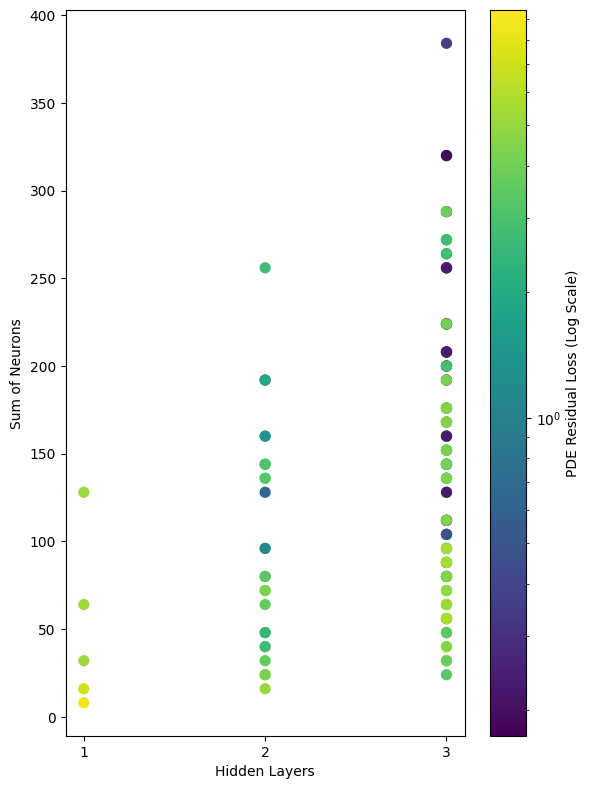

| hidden_layers   | Final Loss       | Training Time   |
|:----------------|:-----------------|:----------------|
| (32, 128, 64)   | $\num{1.73e-01}$ | $2.48$          |
| (128, 32, 64)   | $\num{1.81e-01}$ | $1.77$          |
| (128, 128, 64)  | $\num{1.89e-01}$ | $3.77$          |
| (16, 128, 64)   | $\num{2.00e-01}$ | $2.31$          |
| (64, 32, 64)    | $\num{2.31e-01}$ | $1.50$          |
| (32, 32, 64)    | $\num{2.32e-01}$ | $1.34$          |
| (32, 64, 64)    | $\num{2.32e-01}$ | $1.55$          |
| (64, 128, 64)   | $\num{2.39e-01}$ | $2.87$          |
| (128, 16, 64)   | $\num{2.44e-01}$ | $1.63$          |
| (8, 128, 64)    | $\num{2.51e-01}$ | $1.82$          |
| (16, 32, 64)    | $\num{2.56e-01}$ | $1.28$          |
| (16, 64, 64)    | $\num{2.83e-01}$ | $1.52$          |
| (128, 64, 64)   | $\num{2.87e-01}$ | $2.63$          |
| (64, 64, 64)    | $\num{3.10e-01}$ | $1.76$          |
| (32, 128, 128)  | $\num{3.18e-01}$ | $3.61$          |
| (128, 8, 64)    | $\num{3.37e

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas

df = pandas.DataFrame.from_records(results)
df["sum_neurons"] = df["hidden_layers"].apply(lambda x: sum(x))
df["layers"] = df["hidden_layers"].apply(lambda x: len(x))
df = df.sort_values(by="sum_neurons")

fig, ax = plt.subplots(figsize=(6,8))
sc = ax.scatter(
  df["layers"],
  df["sum_neurons"],
  c=df["final_loss"],
  cmap="viridis",
  norm=colors.LogNorm(),
  s=50,
)
cbar = plt.colorbar(sc)
cbar.set_label("PDE Residual Loss (Log Scale)")

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Sum of Neurons")

ax.set_xticks(range(1, 4))

plt.tight_layout()
plt.savefig("1d_diffusion_neurons_layers_loss.pdf", format="pdf")
plt.show()

# Print 10 best configuration

df_md = df.sort_values(by="final_loss").head(30)
df_md["Final Loss"] = df_md["final_loss"].apply(lambda x: f"$\\num{{{x:.2e}}}$")
df_md["Training Time"] = df_md["training_time"].apply(lambda x: f"${x:.2f}$")
print(df_md[["hidden_layers", "Final Loss", "Training Time"]].to_markdown(index=False))


#### Activation functions

In [11]:
import jax
import pandas

from python.tuning import tune_activation_functions

spatial_size = 10
time_size = 10
epochs = 1000
hidden_layers = [32, 128, 64]
activation_functions = [jax.nn.sigmoid, jax.nn.tanh, jax.nn.silu, jax.nn.relu, jax.nn.leaky_relu, jax.nn.elu]

#results = tune_activation_functions(hidden_layers, activation_functions, spatial_size, time_size, epochs)

df = pandas.DataFrame.from_records(results)
df["Final Loss"] = df["final_loss"].apply(lambda x: f"$\\num{{{x:.2e}}}$")
df["Training time"] = df["training_time"].apply(lambda x: f"${x:.2f}$")

df = df.sort_values(by="final_loss")

print(df[
  [
    "activation_function",
    "Final Loss",
    "Training time",
  ]
].to_markdown(index=False))

| activation_function   | Final Loss       | Training time   |
|:----------------------|:-----------------|:----------------|
| silu                  | $\num{1.28e-03}$ | $3.34$          |
| tanh                  | $\num{1.84e-03}$ | $2.91$          |
| sigmoid               | $\num{2.44e-03}$ | $2.76$          |
| elu                   | $\num{2.85e-03}$ | $2.97$          |
| leaky_relu            | $\num{1.44e-01}$ | $1.21$          |
| relu                  | $\num{1.21e+00}$ | $1.12$          |


##### Neural vs Euler

In [12]:
import jax

from python.heat_equation_jax import HeatEquationSolver, sinusoidal_initial

hidden_layers = [32, 128, 64]
activation_functions = [jax.nn.silu] * len(hidden_layers)

jax_solver = HeatEquationSolver(sinusoidal_initial, hidden_layers, activation_functions)
loss = jax_solver.train_ffnn(10, 10, epochs=5000)

Epoch 0, Loss: 11.388850212097168
Best loss: 11.388850212097168
Epoch 100, Loss: 4.07265043258667
Best loss: 4.07265043258667
Epoch 200, Loss: 0.8037944436073303
Best loss: 0.8037944436073303
Epoch 300, Loss: 0.1263343095779419
Best loss: 0.1263343095779419
Epoch 400, Loss: 0.030273569747805595
Best loss: 0.030273569747805595
Epoch 500, Loss: 0.010253384709358215
Best loss: 0.010253384709358215
Epoch 600, Loss: 0.0060164364986121655
Best loss: 0.0060164364986121655
Epoch 700, Loss: 0.004367190878838301
Best loss: 0.004367190878838301
Epoch 800, Loss: 0.003438956569880247
Best loss: 0.003438956569880247
Epoch 900, Loss: 0.0027826011646538973
Best loss: 0.0027826011646538973
Epoch 1000, Loss: 0.002288850722834468
Best loss: 0.002288850722834468
Epoch 1100, Loss: 0.0019366171909496188
Best loss: 0.0019155145855620503
Epoch 1200, Loss: 0.0016020169714465737
Best loss: 0.0016020169714465737
Epoch 1300, Loss: 0.0014930936740711331
Best loss: 0.0013799290172755718
Epoch 1400, Loss: 0.00117921

Stability condition (should be <= 0.5): 0.5


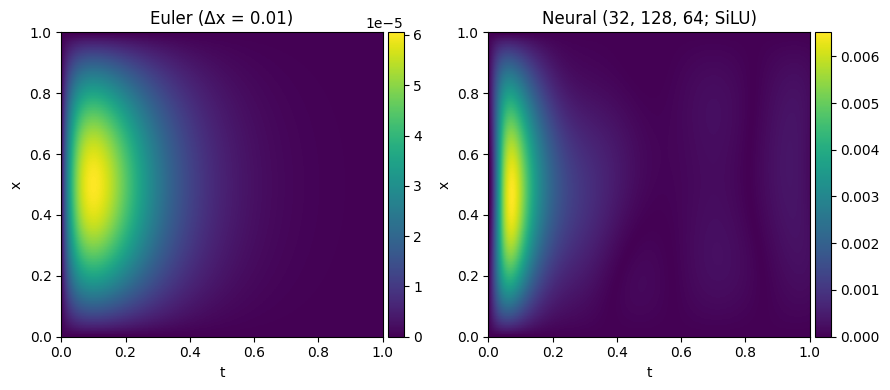

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from python.heat_equation_euler import (
  solve_1d_heat_equation_euler,
  analytic_solution,
  sinusoidal_initial as initial,
)

# Euler
dx = 0.01
dt = 5e-5

u_euler, x, t = heat_equation_forward_euler(
  initial, 
  dx=dx, 
  dt=dt
)

X, T = np.meshgrid(x, t)

# Neural
X_jx = jnp.array(X)
T_jx = jnp.array(T)

X_flat = X_jx.flatten()[:, jnp.newaxis]
T_flat = T_jx.flatten()[:, jnp.newaxis]

u_ffnn = jax_solver.ffnn_trial(jax_solver.params, X_flat, T_flat).reshape(X_jx.shape)

# Analytic
u_exact = analytic_solution(X, T)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

data = {
  "Euler (Δx = 0.01)": u_euler,
  "Neural (32, 128, 64; SiLU)": u_ffnn.T,
}

for i, k in enumerate(data.keys()):
  u_diff = np.abs(u_exact.T - data[k])
  heatmap = axes[i].imshow(
    u_diff, aspect="auto", origin="lower", extent=[0, 1, 0, 1], cmap="viridis"
  )
  axes[i].set_title(k)
  axes[i].set_xlabel("t")
  axes[i].set_ylabel("x")
  divider = make_axes_locatable(axes[i])
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(heatmap, cax=cax)

plt.tight_layout()
plt.savefig("1d_diffusion_euler_neural_absolute_error.pdf", format="pdf")
plt.show()

#### Solving 1D heat equation with explicit Euler scheme

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from python.heat_equation_euler import (
  heat_equation_forward_euler,
  analytic_solution,
  sinusoidal_initial,
)

dx = 0.1
dt = 0.005

u_euler, x, t = heat_equation_forward_euler(
  sinusoidal_initial,
  dx=dx,
  dt=dt,
)

t_points = (0.1, 0.6)

fig, axes = plt.subplots(2, 1, figsize=(6, 8))

for i, ax in enumerate(axes.flat):
  t_index = int(t_points[i] / dt) 
  u_exact = analytic_solution(x, np.array([t[t_index]]))

  ax.plot(x, u_euler[:, t_index], label="Euler" )
  ax.plot(x, u_exact, label="Exact", linestyle="--")
  ax.set_title(f"t = {t[t_index]:.2f}")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.grid(True)
  ax.legend()


fig.tight_layout()
plt.savefig("1d_diffusion_euler_snapshots.pdf", format="pdf")
plt.show()

##### Absolute error

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np


from python.heat_equation_euler import (
  heat_equation_forward_euler,
  analytic_solution,
  sinusoidal_initial,
)

#plt.rcParams["text.usetex"] = True

dxs = [0.1, 0.01]
dts = [0.005, 5e-5]
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for i, ax in enumerate(axes):
  u_euler, x, t = heat_equation_forward_euler(
    sinusoidal_initial,
    dx=dxs[i],
    dt=dts[i],
  )

  X, T = np.meshgrid(x, t)

  u_exact = analytic_solution(X, T)

  u_diff = np.abs(u_exact.T - u_euler)

  heatmap = ax.imshow(u_diff, aspect="auto", origin="lower", extent=[0, 1, 0, 1], cmap="viridis")
  ax.set_title(f"Δx = {dxs[i]}, Δt = {dts[i]}")
  ax.set_xlabel("t")
  ax.set_ylabel("x")

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(heatmap, cax=cax)
  #cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2e}'))


plt.tight_layout()
plt.savefig("1d_diffusion_euler_absolute_error.pdf", format="pdf")
plt.show()

